<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/Gender_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import zipfile
from google.colab import drive

In [2]:
# 1. Import the required libraries (done above)
print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# 2. Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_path = '/content/drive/MyDrive/gender_dataset_face.zip'
extract_path = '/content/gender_dataset'

In [5]:
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully!")
else:
    print("Dataset directory already exists!")


Dataset extracted successfully!


In [9]:
# 3. Load the Dataset
dataset_path = '/content/gender_dataset/gender_dataset_face'

In [12]:
# 4. Convert images to arrays and create labels
def load_dataset(dataset_path, target_size=(224, 224)):
    images = []
    labels = []

    # Assuming dataset structure is: dataset_path/male and dataset_path/female
    male_path = os.path.join(dataset_path, 'man')
    female_path = os.path.join(dataset_path, 'woman')

    # Load male images
    print("Loading male images...")
    for img_name in tqdm(os.listdir(male_path)):
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(male_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(1)  # 1 for male

    # Load female images
    print("Loading female images...")
    for img_name in tqdm(os.listdir(female_path)):
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(female_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(0)  # 0 for female

    return np.array(images), np.array(labels)

In [13]:
X, y = load_dataset(dataset_path)
print(f"Dataset loaded! X shape: {X.shape}, y shape: {y.shape}")

Loading male images...


100%|██████████| 1173/1173 [00:01<00:00, 835.40it/s]


Loading female images...


100%|██████████| 1134/1134 [00:00<00:00, 1183.69it/s]


Dataset loaded! X shape: (2307, 224, 224, 3), y shape: (2307,)


In [15]:
# Normalize pixel values
X = X / 255.0

In [16]:
# 5. Apply Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (1845, 224, 224, 3), Test set: (462, 224, 224, 3)


In [17]:
# 6. Implement Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32
)

In [18]:
# 7. Train the VGG16 model
# Load pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [20]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# Add custom top layers for gender classification
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [22]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [23]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [24]:
# Define callbacks
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/gender_classifier_vgg16.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [25]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [26]:
# Train the model
epochs = 15
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.4884 - loss: 0.8177
Epoch 1: val_accuracy improved from -inf to 0.49134, saving model to /content/drive/MyDrive/gender_classifier_vgg16.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 838ms/step - accuracy: 0.4885 - loss: 0.8169 - val_accuracy: 0.4913 - val_loss: 0.6983
Epoch 2/15
 1/57 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - accuracy: 0.5000 - loss: 0.7539

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.49134
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5000 - loss: 0.7539 - val_accuracy: 0.4913 - val_loss: 0.7024
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4840 - loss: 0.7313
Epoch 3: val_accuracy did not improve from 0.49134
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 470ms/step - accuracy: 0.4839 - loss: 0.7312 - val_accuracy: 0.4913 - val_loss: 0.7003
Epoch 4/15
 1/57 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.5625 - loss: 0.6859
Epoch 4: val_accuracy did not improve from 0.49134
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5625 - loss: 0.6859 - val_accuracy: 0.4913 - val_loss: 0.7002
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.4826 - loss: 0.7088
Epoch 5: val_accuracy improved from 0.49134 to 0.50866, saving model to /content/drive/MyDrive/gender_classifier_vgg16.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 583ms/step - accuracy: 0.4829 - loss: 0.7087 - val_accuracy: 0.5087 - val_loss: 0.6931
Epoch 6/15
 1/57 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.7188 - loss: 0.6373
Epoch 6: val_accuracy did not improve from 0.50866
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7188 - loss: 0.6373 - val_accuracy: 0.5087 - val_loss: 0.6935
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5323 - loss: 0.6964
Epoch 7: val_accuracy did not improve from 0.50866
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 467ms/step - accuracy: 0.5321 - loss: 0.6964 - val_accuracy: 0.4913 - val_loss: 0.6957
Epoch 8/15
 1/57 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.5312 - loss: 0.6958
Epoch 8: val_accuracy did not improve from 0.50866
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5312 - loss: 0.6958 - val_accuracy: 0.4913 - val_loss: 0.6957
Epoch 9/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.5199 - loss: 0.6913
Epoch 9: val_accuracy did not impr

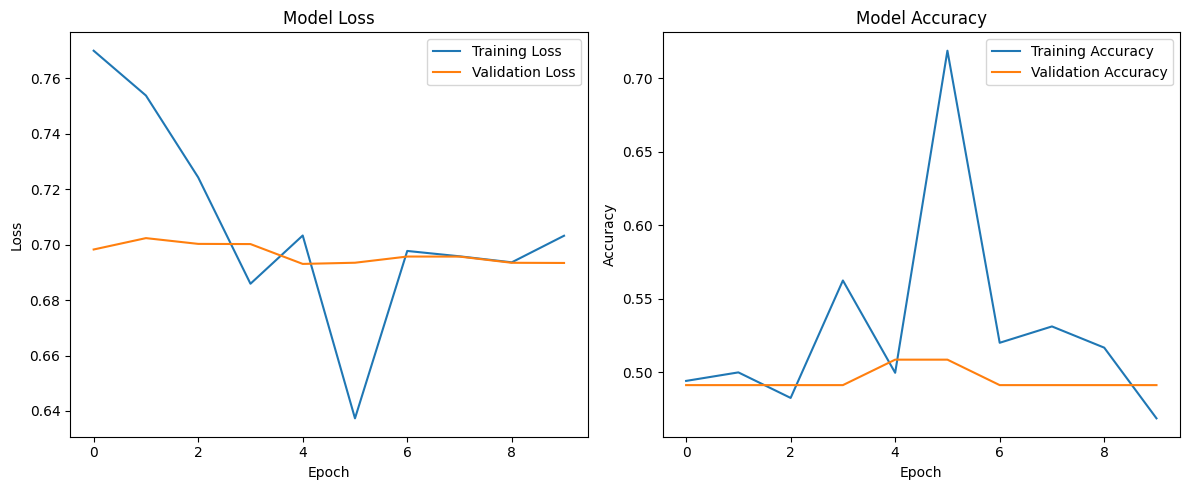

In [27]:
 plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/gender_classifier_performance.png')
plt.show()

In [28]:
# 9. Test on a sample image with YOLO face detection
def download_yolo_weights():
    # Download YOLOv4-tiny weights and config files
    !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-face.weights -O /content/yolov4-face.weights
    !wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-face.cfg -O /content/yolov4-face.cfg
